In [1]:
import pandas as pd
import numpy as np
from pylab import *

# Для работы с матрицами
from scipy.sparse import csr_matrix
 
# Модель второго уровня
from lightgbm import LGBMClassifier

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from datetime import datetime, date, time, timedelta

In [4]:
import pickle

In [5]:
from src.metrics import money_precision_at_k,  recall_at_k
from src.utils import prefilter_items, postfilter_items, popularity_recommendation
from src.recommenders import MainRecommender
from src.feature import new_item_features, new_user_features, time_features

In [6]:
path = 'C:/Users/user/Documents/mydocs/rs_geek_brains/final_project/data/'
data = pd.read_csv(path + 'retail_train.csv')
user_features = pd.read_csv(path + 'hh_demographic.csv')
item_features = pd.read_csv(path +  'product.csv')

In [7]:
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

In [8]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

## Data Exploration 

In [14]:
data.describe

<bound method NDFrame.describe of          user_id    basket_id  day   item_id  quantity  sales_value  store_id  \
0           2375  26984851472    1   1004906         1         1.39       364   
1           2375  26984851472    1   1033142         1         0.82       364   
2           2375  26984851472    1   1036325         1         0.99       364   
3           2375  26984851472    1   1082185         1         1.21       364   
4           2375  26984851472    1   8160430         1         1.50       364   
...          ...          ...  ...       ...       ...          ...       ...   
2396799     1613  41655820646  663  16102849         1         2.00      3262   
2396800     1001  41655829421  663  13217063         1         1.69      3131   
2396801     1001  41655829421  663  13217800         1         1.69      3131   
2396802     1167  41656790510  663   6410462     22451        43.98      3385   
2396803     1167  41656790510  663   6430664         1         8.00      33

In [ ]:
#есть ли NAN значения

In [17]:
data.isnull().sum()

user_id              0
basket_id            0
day                  0
item_id              0
quantity             0
sales_value          0
store_id             0
retail_disc          0
trans_time           0
week_no              0
coupon_disc          0
coupon_match_disc    0
price                0
dtype: int64

In [18]:
item_features.isnull().sum()

item_id                 0
manufacturer            0
department              0
brand                   0
commodity_desc          0
sub_commodity_desc      0
curr_size_of_product    0
dtype: int64

In [19]:
user_features.isnull().sum()

age_desc               0
marital_status_code    0
income_desc            0
homeowner_desc         0
hh_comp_desc           0
household_size_desc    0
kid_category_desc      0
user_id                0
dtype: int64

In [9]:
#уберем товары, у которых нет продаж 
data = data[data['quantity'] != 0]

## Популярные товары 

In [29]:
pop = data.groupby('item_id')['user_id'].nunique().reset_index()
pop.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

In [36]:
pop.groupby('share_unique_users')['item_id'].count().reset_index().sort_values(by='item_id').head(10).style.bar()

,share_unique_users,item_id
539,2039,1
292,295,1
422,475,1
421,474,1
420,473,1
419,472,1
418,471,1
417,469,1
416,467,1
424,478,1


In [12]:
pop['share_unique_users'].sum()

1308399

In [38]:
pop['share'] = pop['share_unique_users']/pop['share_unique_users'].sum()*100

In [39]:
pop.head()

,item_id,share_unique_users,share
0,25671,3,0.000229
1,26081,1,0.000076
2,26093,1,0.000076
3,26190,1,0.000076
4,26355,1,0.000076


In [40]:
## наиболее популярные товары 

In [41]:
len(pop[pop['share_unique_users'] > 1000].sort_values(by='share', ascending = False))

27

In [52]:
pop[pop['share_unique_users'] > 1000].sort_values(by='share', ascending = False).head(10) 

,item_id,share_unique_users,share
34968,1082185,2039,0.155839
23798,981760,1584,0.121064
25284,995242,1419,0.108453
29126,1029743,1342,0.102568
8047,840361,1318,0.100734
36725,1098066,1280,0.097829
56080,6534178,1280,0.097829
6467,826249,1279,0.097753
39916,1127831,1262,0.096454
12861,883404,1208,0.092327


In [16]:
pop['cat_num'] = pd.qcut(pop['share'], 50,  duplicates ='drop')

In [17]:
pop.head()

,item_id,share_unique_users,share,cat_num
0,25671,3,0.000229,"(0.000153, 0.000229]"
1,26081,1,0.000076,"(-0.0009236, 0.000153]"
2,26093,1,0.000076,"(-0.0009236, 0.000153]"
3,26190,1,0.000076,"(-0.0009236, 0.000153]"
4,26355,1,0.000076,"(-0.0009236, 0.000153]"


In [18]:
pop_sum = pop.groupby('cat_num')['item_id'].count().reset_index()

In [19]:
pop_sum.rename(columns={'item_id': 'item_count'}, inplace=True)

In [20]:
pop_sum.head()

,cat_num,item_count
0,"(-0.0009236, 0.000153]",46412
1,"(0.000153, 0.000229]",5833
2,"(0.000229, 0.000306]",3941
3,"(0.000306, 0.000382]",3016
4,"(0.000382, 0.000459]",2280


In [21]:
pop_sum['share_item'] = pop_sum.item_count/ pop_sum.item_count.sum()*100

In [22]:
pop_sum[['cat_num', 'item_count', 'share_item']].style.bar()

,cat_num,item_count,share_item
0,"(-0.0009236, 0.000153]",46412,52.299336
1,"(0.000153, 0.000229]",5833,6.572913
2,"(0.000229, 0.000306]",3941,4.440914
3,"(0.000306, 0.000382]",3016,3.398578
4,"(0.000382, 0.000459]",2280,2.569217
5,"(0.000459, 0.000535]",1898,2.138760
6,"(0.000535, 0.000611]",1621,1.826623
7,"(0.000611, 0.000688]",1365,1.538149
8,"(0.000688, 0.000764]",1218,1.372503
9,"(0.000764, 0.000917]",2028,2.285251


In [25]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88743 entries, 0 to 88742
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   item_id             88743 non-null  int64   
 1   share_unique_users  88743 non-null  int64   
 2   share               88743 non-null  float64 
 3   cat_num             88743 non-null  category
dtypes: category(1), float64(1), int64(2)
memory usage: 2.1 MB


In [50]:
pop.head()

,item_id,share_unique_users,share,cat_num
0,25671,3,0.000229,"(0.000153, 0.000229]"
1,26081,1,0.000076,"(-0.0009236, 0.000153]"
2,26093,1,0.000076,"(-0.0009236, 0.000153]"
3,26190,1,0.000076,"(-0.0009236, 0.000153]"
4,26355,1,0.000076,"(-0.0009236, 0.000153]"


In [53]:
pop.loc[pop['share_unique_users']<=2]

,item_id,share_unique_users,share,cat_num
1,26081,1,0.000076,"(-0.0009236, 0.000153]"
2,26093,1,0.000076,"(-0.0009236, 0.000153]"
3,26190,1,0.000076,"(-0.0009236, 0.000153]"
4,26355,1,0.000076,"(-0.0009236, 0.000153]"
5,26426,1,0.000076,"(-0.0009236, 0.000153]"
...,...,...,...,...
88734,17959243,2,0.000153,"(-0.0009236, 0.000153]"
88735,17959460,1,0.000076,"(-0.0009236, 0.000153]"
88738,17991689,1,0.000076,"(-0.0009236, 0.000153]"
88739,17991691,1,0.000076,"(-0.0009236, 0.000153]"


In [56]:
pop.loc[pop['share'] > 0.00948].sort_values(by='share_unique_users', ascending = False)

,item_id,share_unique_users,share,cat_num
34968,1082185,2039,0.155839,"(0.00948, 0.156]"
23798,981760,1584,0.121064,"(0.00948, 0.156]"
25284,995242,1419,0.108453,"(0.00948, 0.156]"
29126,1029743,1342,0.102568,"(0.00948, 0.156]"
8047,840361,1318,0.100734,"(0.00948, 0.156]"
...,...,...,...,...
11940,874643,125,0.009554,"(0.00948, 0.156]"
9427,852317,125,0.009554,"(0.00948, 0.156]"
73274,12256522,125,0.009554,"(0.00948, 0.156]"
36163,1093359,125,0.009554,"(0.00948, 0.156]"


In [37]:
pop_bx = pop['share_unique_users'].loc[pop['share'] < 0.00948] 

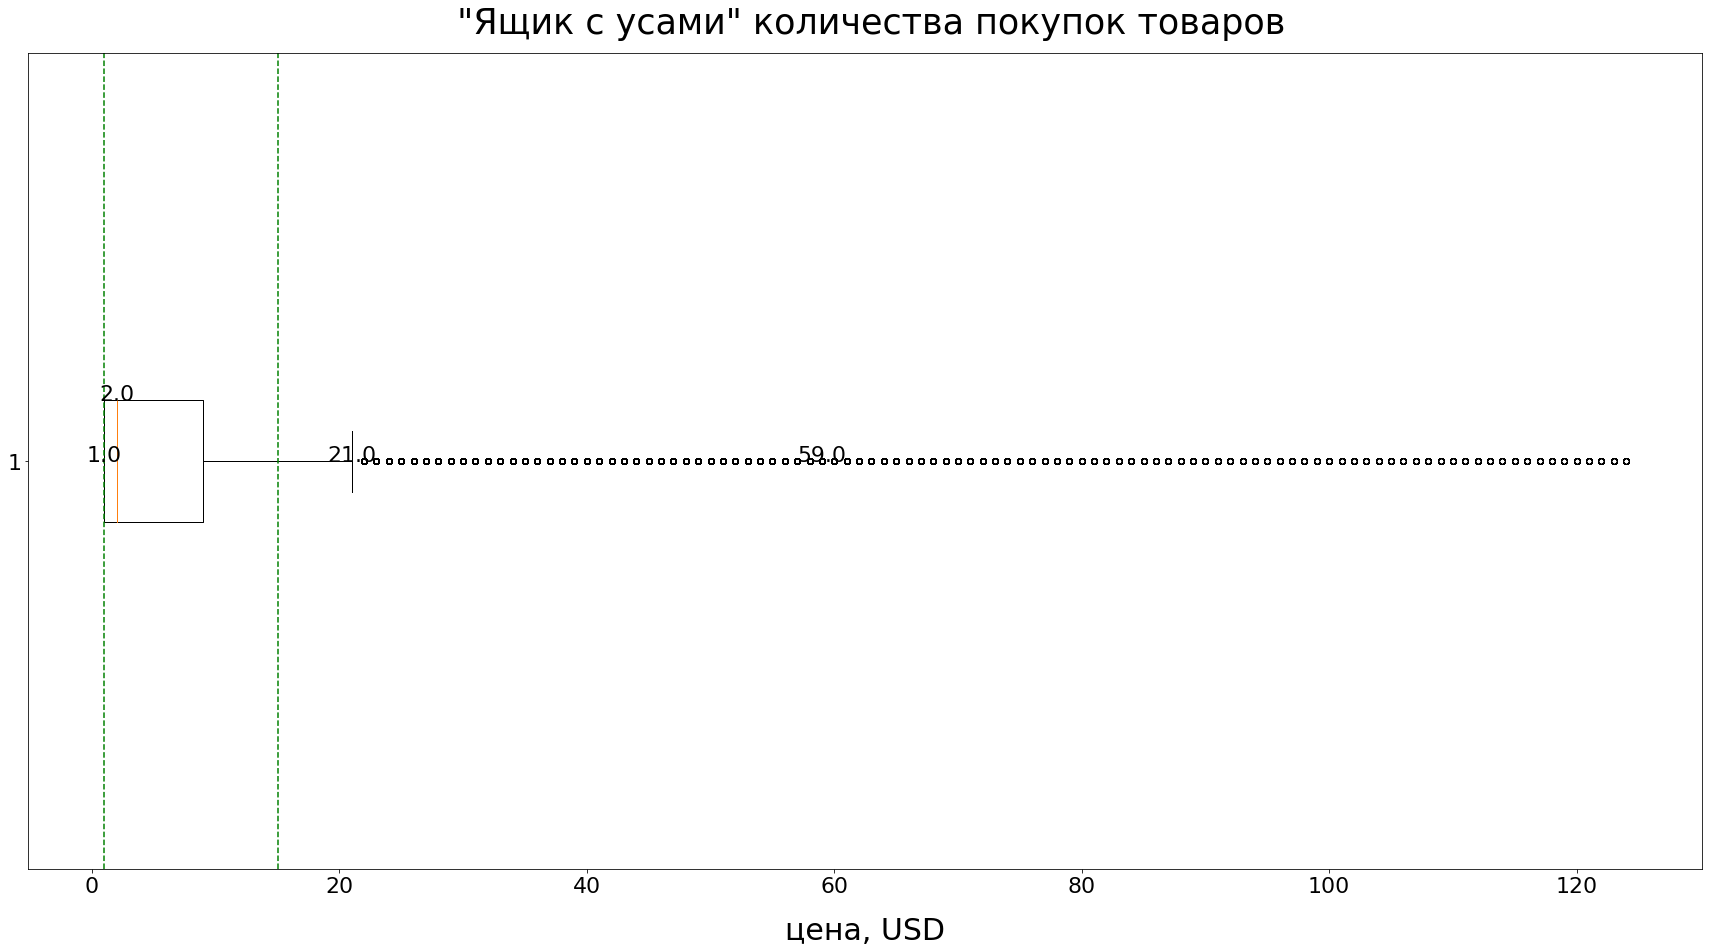

In [38]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30, 15))

# get dictionary returned from boxplot
bp_dict = boxplot(pop_bx , vert=False)

for line in bp_dict['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, '%.1f' % x, horizontalalignment='center') # draw above, centered

for line in bp_dict['whiskers']:
    # get position data for median line
    x1, y1 = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x1, y1, '%.1f' % x1, horizontalalignment='center') # draw above, centered

for line in bp_dict['fliers']:
    # get position data for median line
    x2, y2 = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x2, y2, '%.1f' % x2, horizontalalignment='center') # draw above, centered
plt.title(' "Ящик с усами" количества покупок товаров', pad=20, fontsize= 35)
plt.axvline(x=1, ls = '--', color = 'g')
plt.axvline(x=15, ls = '--', color = 'g')
plt.xlabel('цена, USD', fontsize=30, labelpad=20)

fig.savefig('box_plot_pop.png')

In [26]:
low_pop = [x for x in pop['item_id'][pop['share'] < 0.0002]]

In [27]:
len(low_pop)

46412

In [65]:
item_features[item_features['item_id'].isin(low_pop)].head(5)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
23,27479,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHITE BREAD,20 OZ
32,27658,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHITE BREAD,20 OZ
73,28272,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 QT
90,28897,69,GROCERY,Private,EGGS,EGGS - X-LARGE,A D 1 DZ


In [61]:
top_pop = [x for x in pop['item_id'][pop['share'] > 0.1]]

In [62]:
item_features[item_features['item_id'].isin(top_pop)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8281,840361,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ
24250,981760,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ
25754,995242,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,
29657,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA
35576,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB


## Цена 

In [43]:
data = data[(data.sales_value >0) & (data.quantity >0)]

In [44]:
#определим цену товара 
data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
#считаем количество покупок 
price_pop = data.groupby('price')['user_id'].count().reset_index()
price_pop.rename(columns={'user_id': 'sales_quantity'}, inplace=True)

In [46]:
price_pop['share'] = price_pop['sales_quantity']/price_pop['sales_quantity'].sum()*100

In [47]:
price_pop.head()

,price,sales_quantity,share
0,0.001660,1,0.000042
1,0.001689,1,0.000042
2,0.001699,1,0.000042
3,0.001709,1,0.000042
4,0.001709,1,0.000042


In [48]:
ddd = [x for x in range(40)]

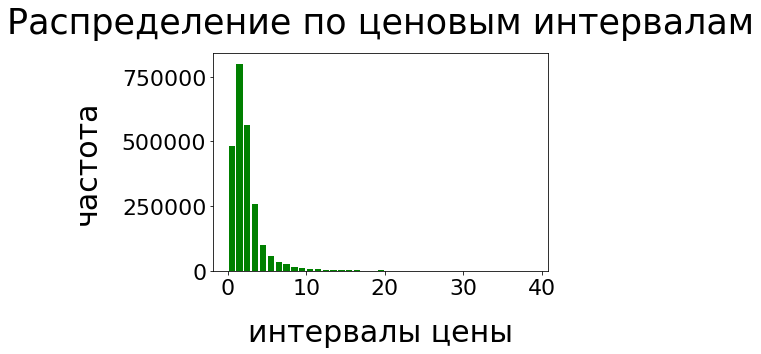

In [49]:
plt.rcParams.update({'font.size': 22})
data[['price']].plot(kind='hist',bins=ddd,rwidth=0.8,  color='green', legend=None)
plt.xlabel('интервалы цены', fontsize=30, labelpad=20)
plt.ylabel('частота', fontsize=30, labelpad=20)
plt.title('Распределение по ценовым интервалам', pad=20, fontsize= 35)
plt.savefig('price_disctribution.png')

In [17]:
small_bx = data['price'].loc[data['price']<20]

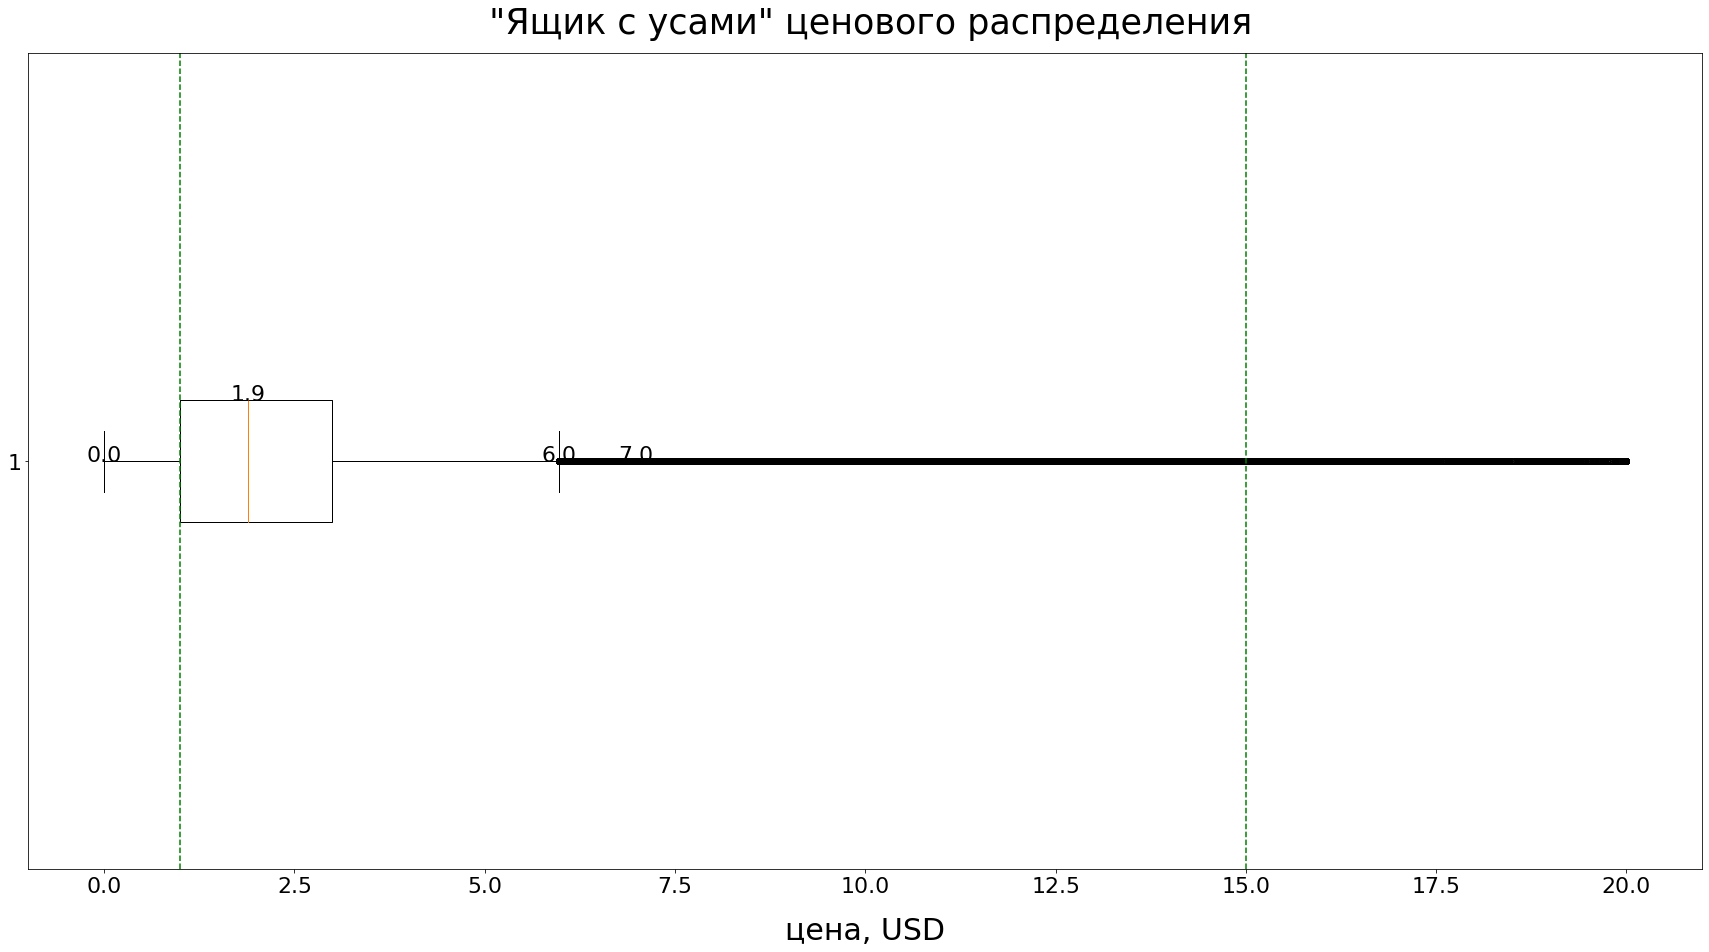

In [34]:
from pylab import *

plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(30, 15))

# get dictionary returned from boxplot
bp_dict = boxplot(small_bx , vert=False)

for line in bp_dict['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, '%.1f' % x, horizontalalignment='center') # draw above, centered

for line in bp_dict['whiskers']:
    # get position data for median line
    x1, y1 = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x1, y1, '%.1f' % x1, horizontalalignment='center') # draw above, centered

for line in bp_dict['fliers']:
    # get position data for median line
    x2, y2 = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x2, y2, '%.1f' % x2, horizontalalignment='center') # draw above, centered
plt.title(' "Ящик с усами" ценового распределения', pad=20, fontsize= 35)
plt.axvline(x=1, ls = '--', color = 'g')
plt.axvline(x=15, ls = '--', color = 'g')
plt.xlabel('цена, USD', fontsize=30, labelpad=20)

fig.savefig('box_plot_small.png')

In [19]:
for line in bp_dict['whiskers']:
    x, y = line.get_xydata()[1]
    print (x,y)

0.00165959800848239 1.0
5.975 1.0


In [ ]:
## USER

In [51]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [53]:
user_features['age'] = user_features['age_desc'].replace(
        {'65+': 70, '45-54': 50, '25-34': 30, '35-44': 40, '19-24':20, '55-64':60})
user_features = user_features.drop('age_desc', axis=1)

In [54]:
user_features.head()

,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age
0,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,70
1,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,50
2,U,25-34K,Unknown,2 Adults Kids,3,1,8,30
3,U,75-99K,Homeowner,2 Adults Kids,4,2,13,30
4,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,50


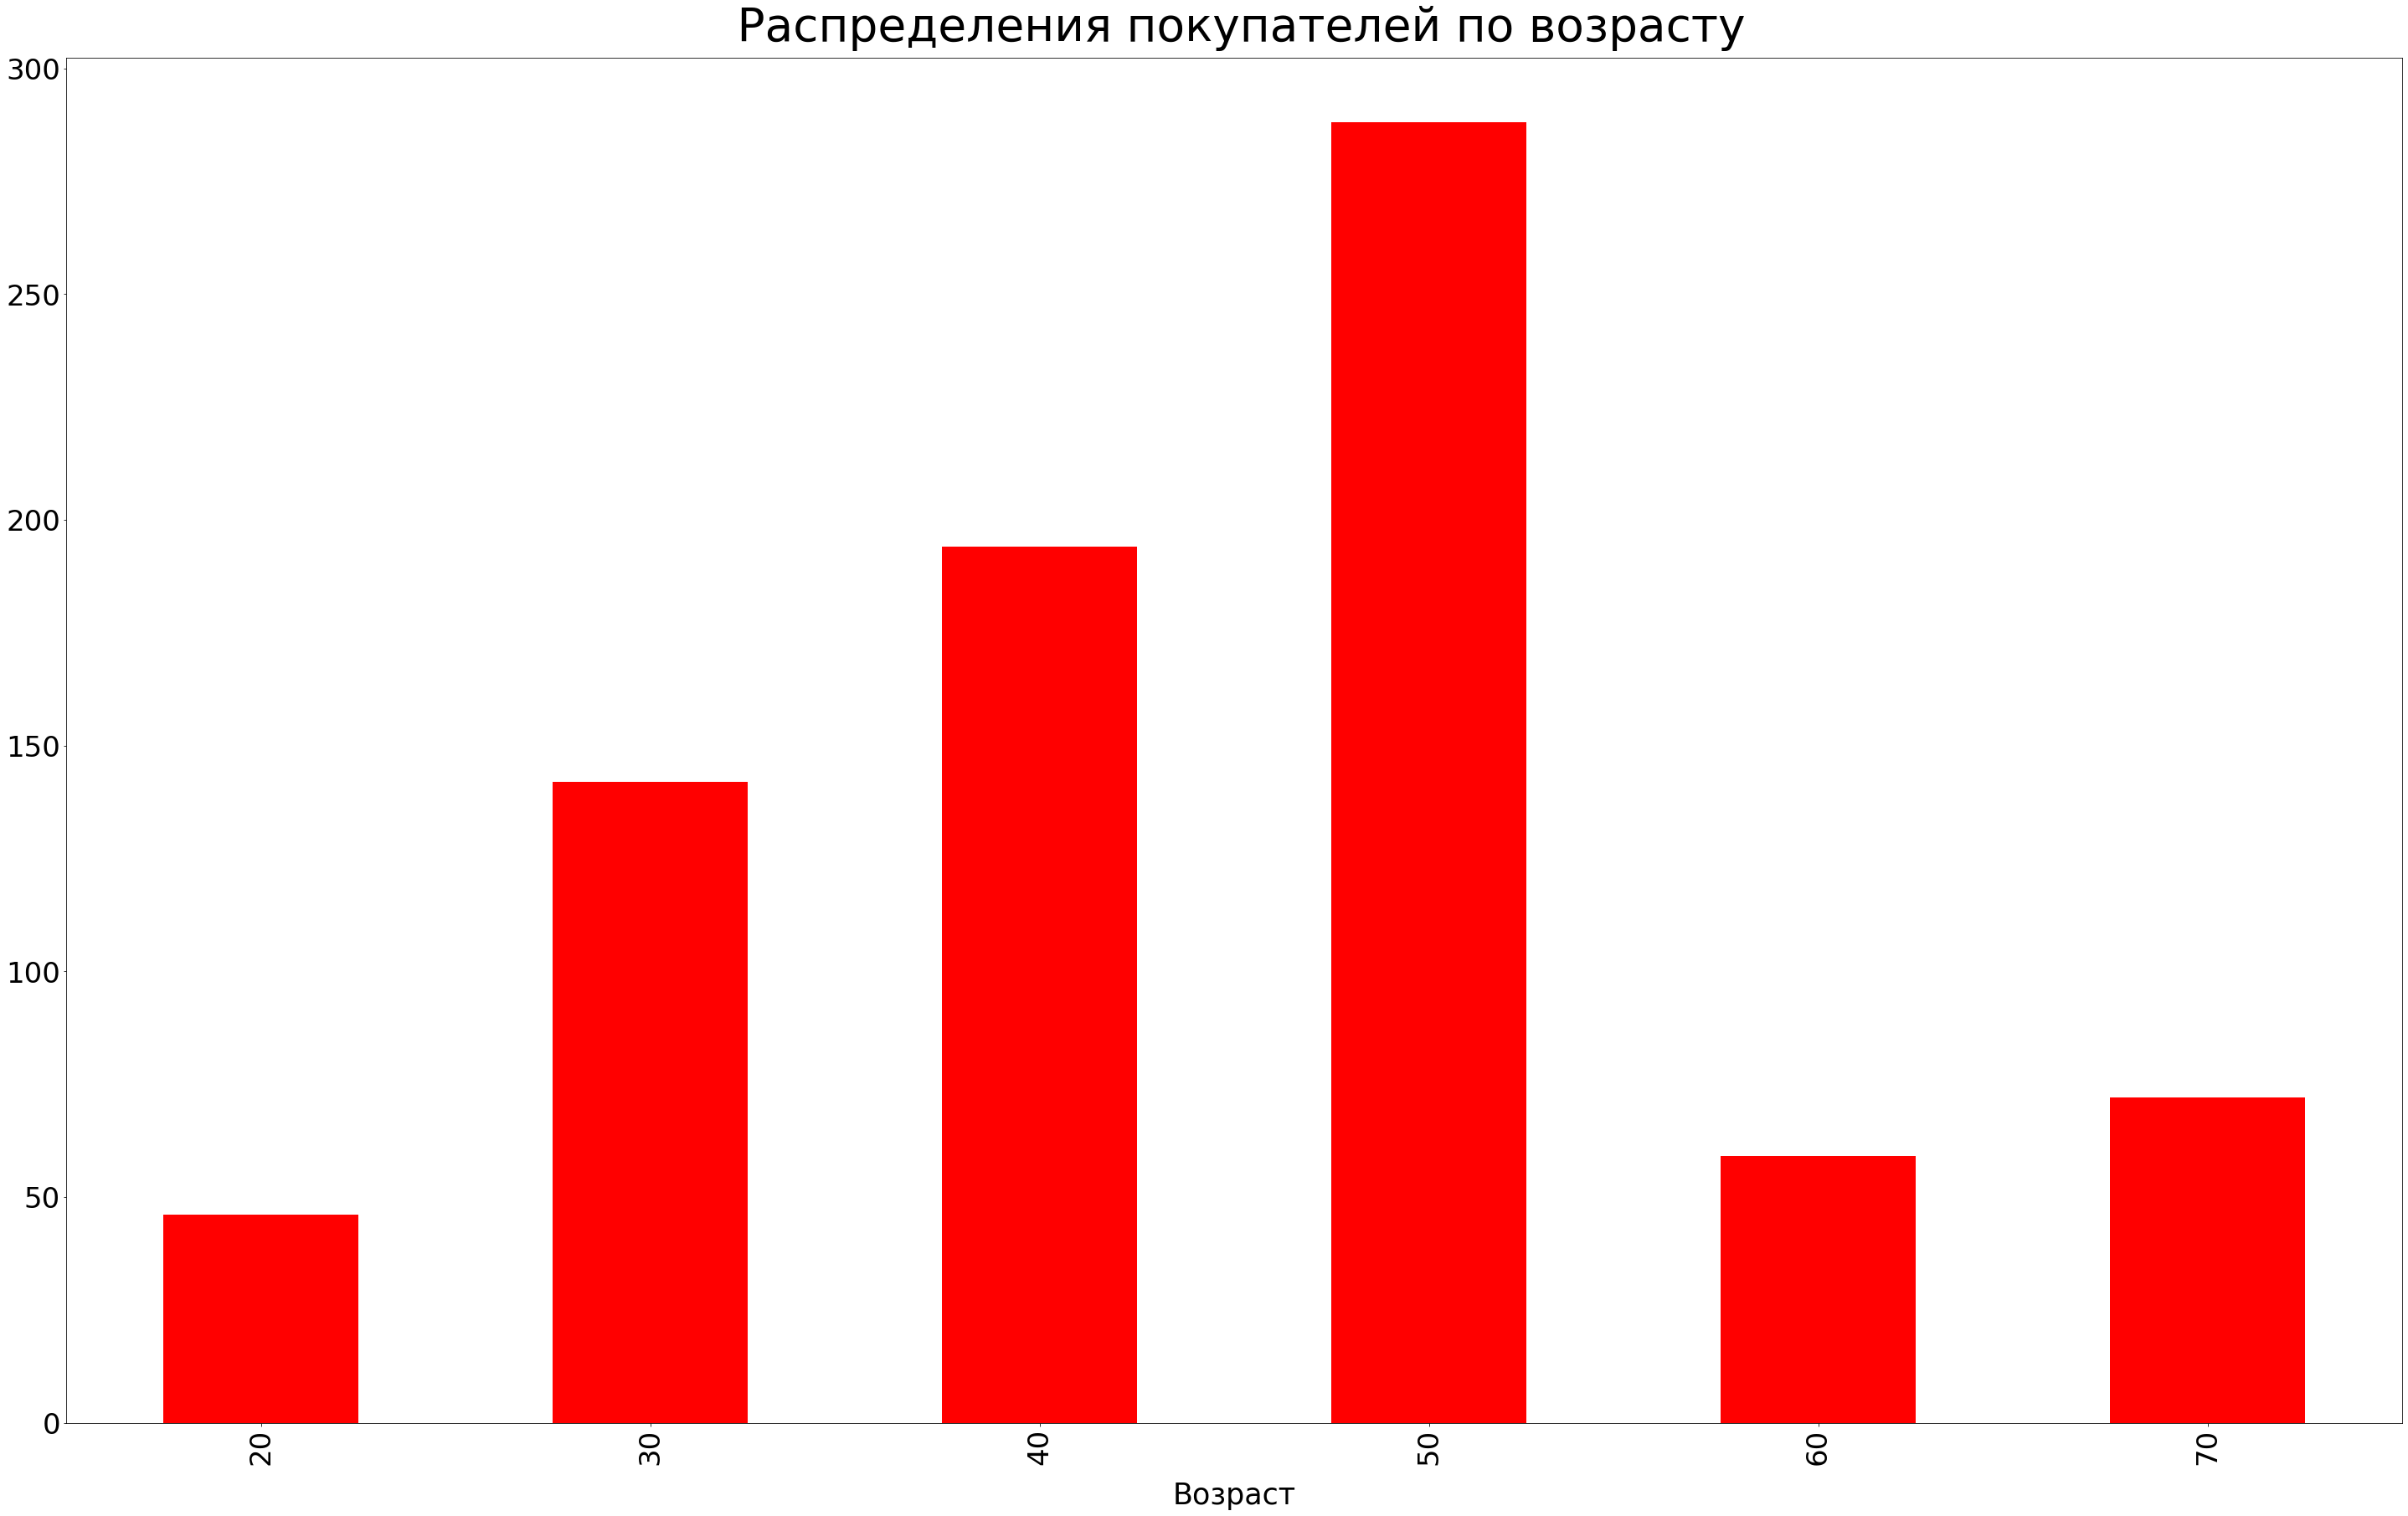

In [80]:
params = {'axes.titlesize':'32',
          'xtick.labelsize':'34',
          'ytick.labelsize':'34',
          'font.size': 22}
matplotlib.rcParams.update(params)
user_features.groupby('age')['user_id'].count().plot(kind='bar',stacked=True,legend=False, figsize=(50, 30), color='r')

plt.xlabel('Возраст',  labelpad=20,  fontsize= 35)
plt.title(' Распределения покупателей по возрасту', pad=20,  fontsize= 55 )
plt.savefig('age_distribution.png')

In [83]:
##### Доход
user_features['income'] = user_features['income_desc'].replace(
        {'35-49K': 45,
     '50-74K': 70,
     '25-34K': 30,
     '75-99K': 95,
     'Under 15K': 15,
     '100-124K': 120,
     '15-24K': 20,
     '125-149K': 145,
     '150-174K': 170,
     '250K+': 250,
     '175-199K': 195,
     '200-249K': 245}
    )
user_features = user_features.drop('income_desc', axis=1)

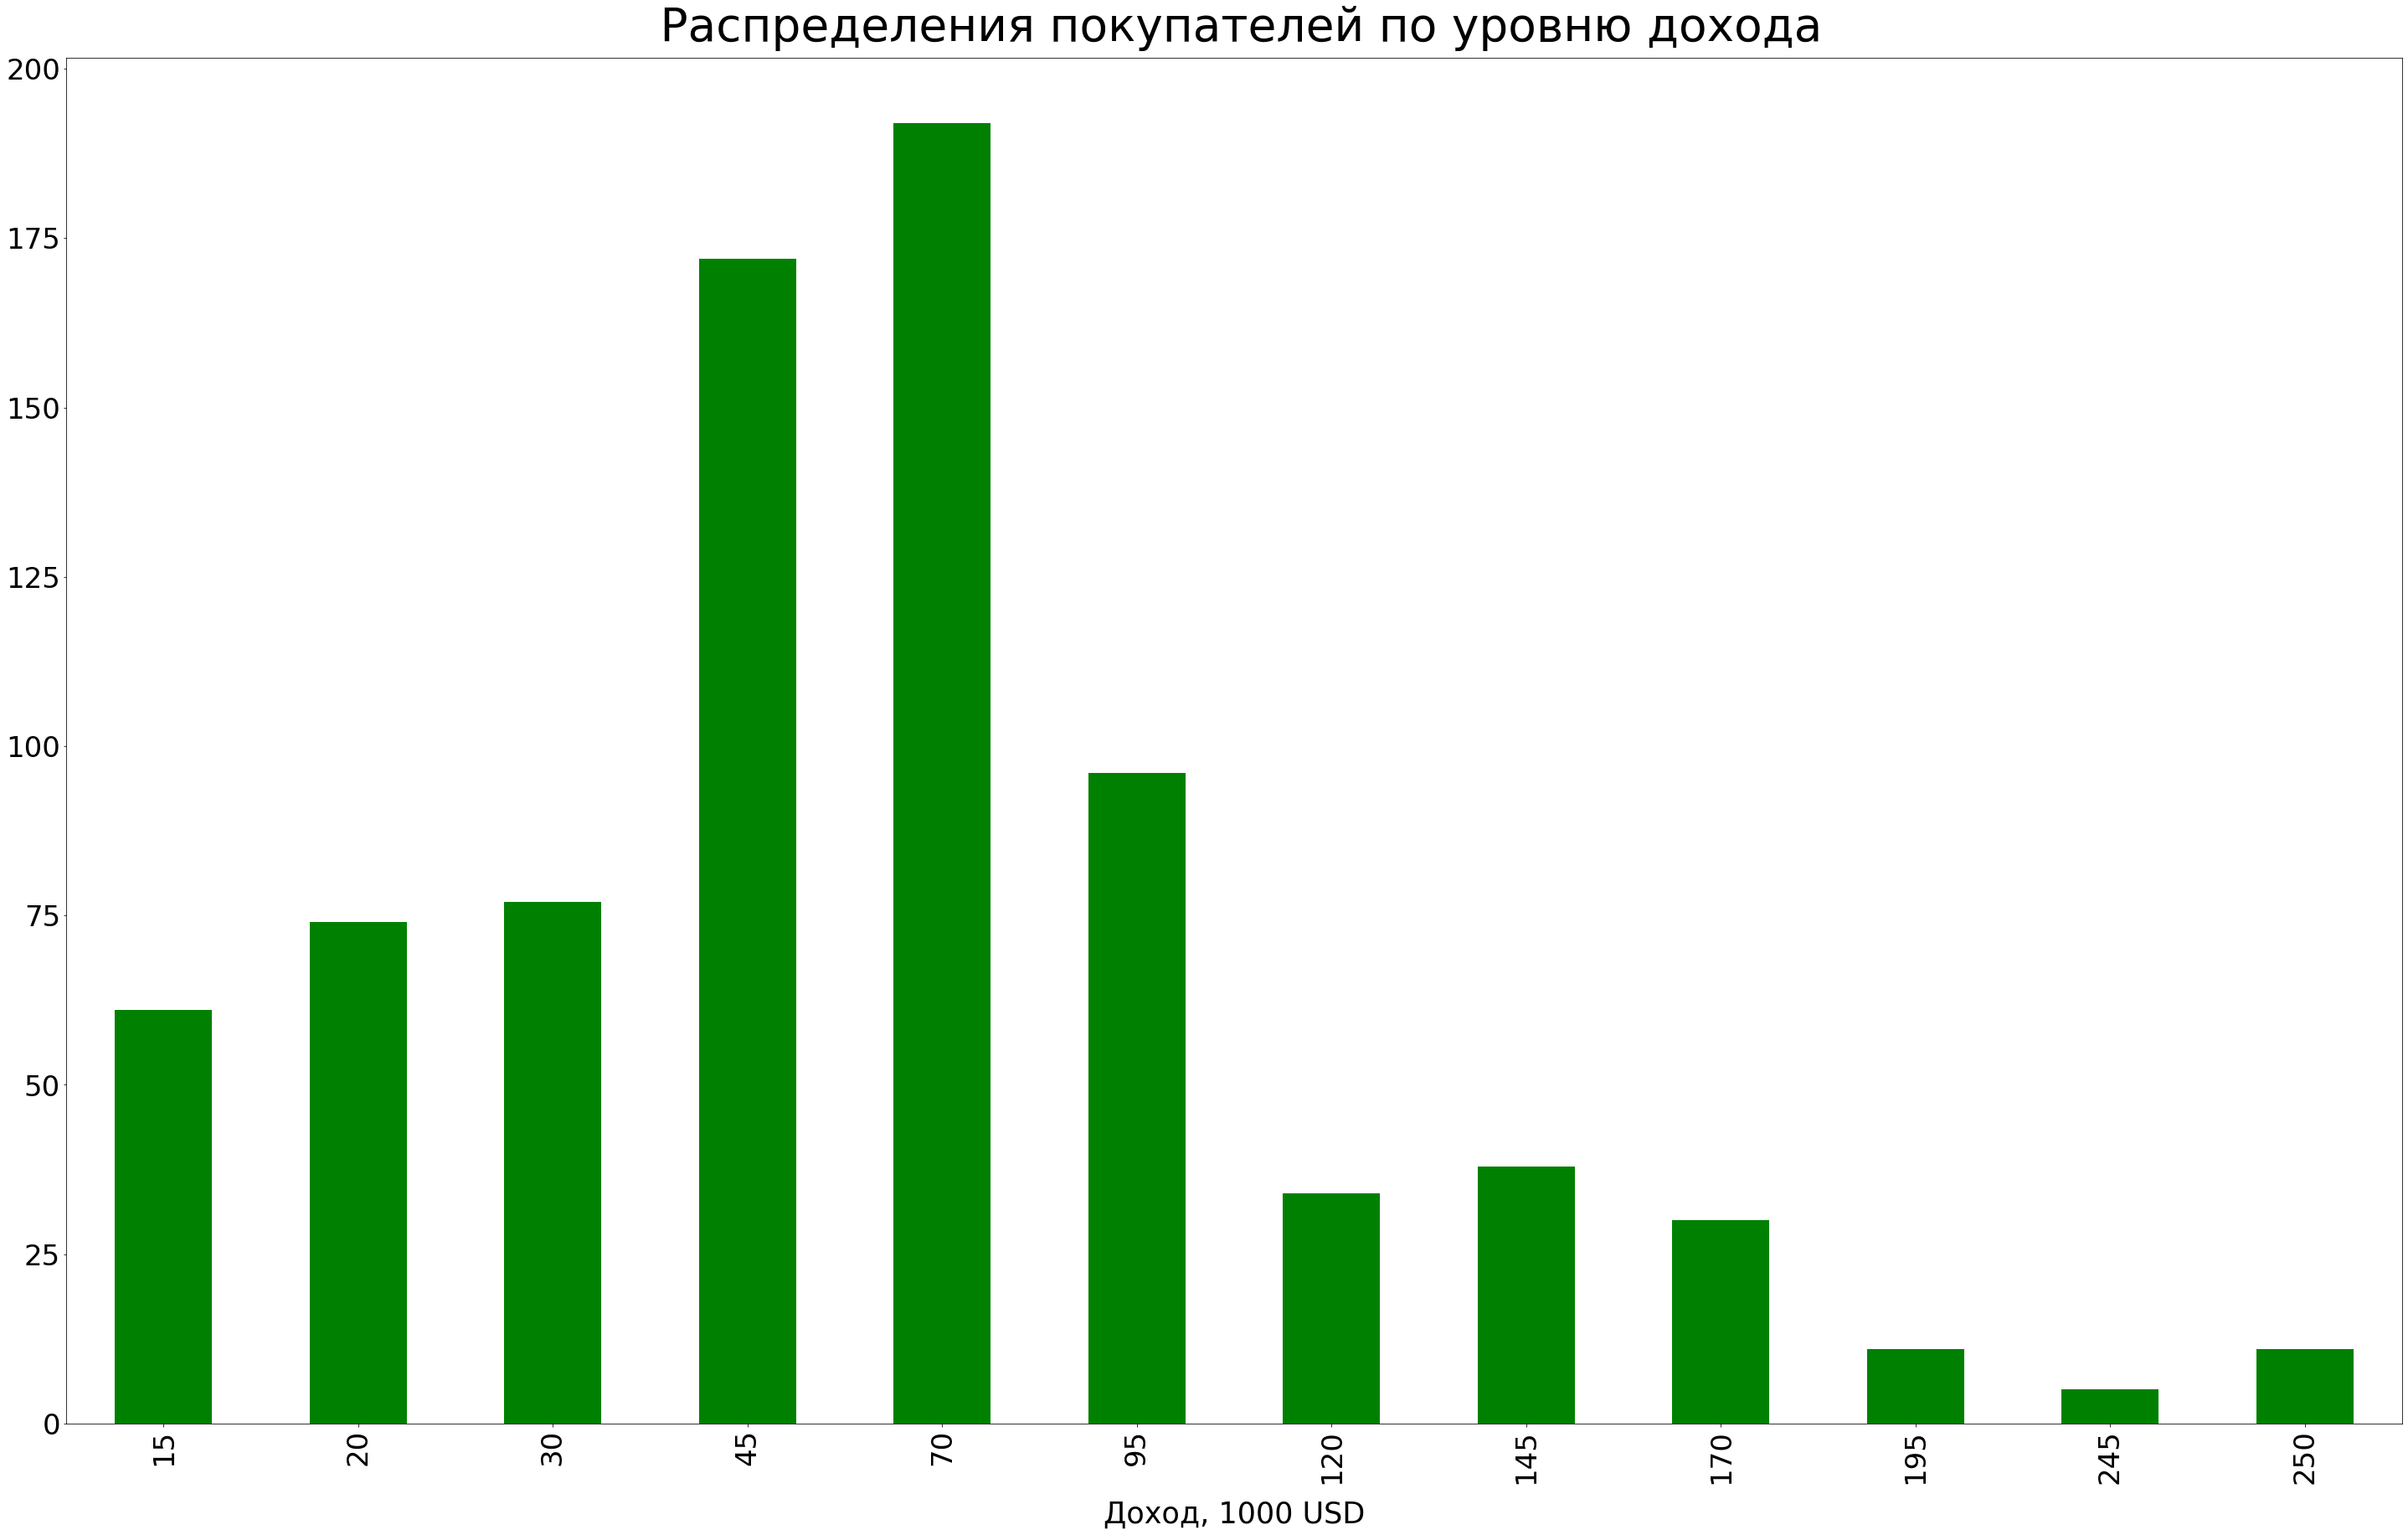

In [86]:
params = {'axes.titlesize':'32',
          'xtick.labelsize':'34',
          'ytick.labelsize':'34',
          'font.size': 22}
matplotlib.rcParams.update(params)
user_features.groupby('income')['user_id'].count().plot(kind='bar',stacked=True,legend=False, figsize=(50, 30), color='g')

plt.xlabel('Доход, 1000 USD',  labelpad=20,  fontsize= 35)
plt.title(' Распределения покупателей по уровню дохода', pad=20,  fontsize= 55 )
plt.savefig('revenue_distribution.png')

In [88]:
user_features.income.mean()

69.68164794007491

In [100]:
#Зависимость дохода от возраста
user_features['income'].corr(user_features['age'])

0.0005656921380010857

## item profile 

In [168]:
department_size = pd.DataFrame(item_features.groupby('department')['item_id'].nunique()).reset_index()
department_size.columns = ['department', 'n_items']

In [169]:
item_sales = data.groupby('item_id')['sales_value'].sum().reset_index()

In [170]:
item_features = item_features.merge(item_sales, on='item_id', how='left')

In [171]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,sales_value
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,20.94
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.99
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1.59
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1.54
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,1.98


In [172]:
department_sales = item_features.groupby('department')['sales_value'].sum().reset_index()
department_sales = department_sales.loc[department_sales['sales_value']!=0]

In [173]:
department_size = department_size.merge(department_sales, on='department', how='left')

In [174]:
department_size['h_mean'] = department_size.sales_value/ (department_size.sales_value/department_size.n_items)

In [178]:
department_size.sort_values(by = 'h_mean', ascending = False).style.bar()

,department,n_items,sales_value,h_mean
17,GROCERY,39021,3769171.070001,39021.000000
10,DRUG GM,31529,972647.610000,31529.000000
33,PRODUCE,3118,515212.520000,3118.000000
5,COSMETICS,3011,29681.830000,3011.000000
26,NUTRITION,2914,88572.370000,2914.000000
21,MEAT,2544,509933.080000,2544.000000
22,MEAT-PCKGD,2427,381941.190000,2427.000000
8,DELI,2354,240882.800000,2354.000000
27,PASTRY,2149,112866.240000,2149.000000
12,FLORAL,938,35706.770000,938.000000
